In [1]:
import torch
import xutorch

In [2]:
args = {
    'seed': 42,
    'lr': 0.00005,
    'num_epochs': 10000,
    'batch_size': 16,
    'early_stop': 500,
    'save_path': 'weights/hw1_model.pth'
}

In [3]:
train_loader, train_dataset = xutorch.dataset.prep_dataloader(
    dataset_name='BOSTON',
    download=True,
    train=True,
    batch_size=args['batch_size'],
    test_ratio=0.25,
    transform=True
)
val_loader, val_dataset = xutorch.dataset.prep_dataloader(
    dataset_name='BOSTON',
    download=True,
    train=False,
    batch_size=args['batch_size'],
    test_ratio=0.25,
    transform=True
)

Finished reading the train set of BOSTON Dataset (381 samples found, each dim = 13)
Finished reading the val set of BOSTON Dataset (125 samples found, each dim = 13)


In [4]:
# 设置随机种子
xutorch.misc.set_seeds(42)

# 获取计算设备
device = xutorch.misc.get_device()

# 创建一个线性回归模型并放到计算设备上
model = xutorch.model.Linear(input_dim=train_loader.dataset.dim).to(device)

# 创建一个SGD优化器
optimizer = xutorch.optim.SimpleSGD(model.parameters(), lr=args['lr'], momentum=0.9)

# 创建一个MSE损失函数
criterion = xutorch.loss.MSE()


In [5]:
loss_record = {
    'train': [],        # 记录在训练集上的loss
    'val': []           # 记录在验证集上的loss
}

min_val_loss = 0        # 验证集上的最小loss
min_val_loss_epoch = 0  # 验证集上的最小loss对应的epoch
early_stop_cnt = 0      # 早停epochs数，超过阈值时早停

for epoch in range(args['num_epochs']):
    train_loss = 0

    model.train()
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        # 前向传播
        outputs = model(inputs)

        # 计算loss
        loss = criterion(outputs, targets)

        # 梯度清零，反向传播，参数更新
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # 记录在训练集上的平均loss
    loss_record['train'].append(train_loss / len(train_dataset))

    val_loss = 0

    model.eval()
    for batch_idx, (inputs, targets) in enumerate(val_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, targets)
        val_loss += loss.item()
    loss_record['val'].append(val_loss / len(val_dataset))

    # 打擂法记录最小loss及其对应的epoch和weights
    if epoch == 0 or val_loss < min_val_loss:
        min_val_loss = val_loss
        min_val_loss_epoch = epoch
        print(f'Saving model (epoch = {epoch + 1 : 4d}, loss = {min_val_loss : .4f})')
        torch.save(model.state_dict(), args['save_path'])
        # 模型性能进步，早停轮数清零
        early_stop_cnt = 0
    else:
        # 模型性能未进步，计入早停轮数
        early_stop_cnt += 1

    # 早停轮数超过阈值
    if early_stop_cnt > args['early_stop']:
        print('**EARLY STOP**')
        break

    # 每10轮打印训练集和验证集上的平均loss
    if epoch % 10 == 9:
        print('[{:03d}/{:03d}] Train Loss: {:3.6f} | Val loss: {:3.6f}'.format(
            epoch + 1, args['num_epochs'], train_loss / len(train_dataset), train_loss / len(train_dataset), val_loss / len(val_dataset)))

Saving model (epoch =    1, loss =  5032.8027)
Saving model (epoch =    2, loss =  4768.5230)
Saving model (epoch =    3, loss =  4512.2597)
Saving model (epoch =    4, loss =  4292.4982)
Saving model (epoch =    5, loss =  4085.9280)
Saving model (epoch =    6, loss =  3885.4887)
Saving model (epoch =    7, loss =  3699.9815)
Saving model (epoch =    8, loss =  3535.5713)
Saving model (epoch =    9, loss =  3379.0991)
Saving model (epoch =   10, loss =  3222.6376)
[010/10000] Train Loss: 22.740562 | Val loss: 22.740562
Saving model (epoch =   11, loss =  3085.7934)
Saving model (epoch =   12, loss =  2950.0511)
Saving model (epoch =   13, loss =  2825.0238)
Saving model (epoch =   14, loss =  2705.6270)
Saving model (epoch =   15, loss =  2590.1955)
Saving model (epoch =   16, loss =  2482.3598)
Saving model (epoch =   17, loss =  2381.4464)
Saving model (epoch =   18, loss =  2282.9210)
Saving model (epoch =   19, loss =  2188.8887)
Saving model (epoch =   20, loss =  2100.2791)
[020

In [6]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

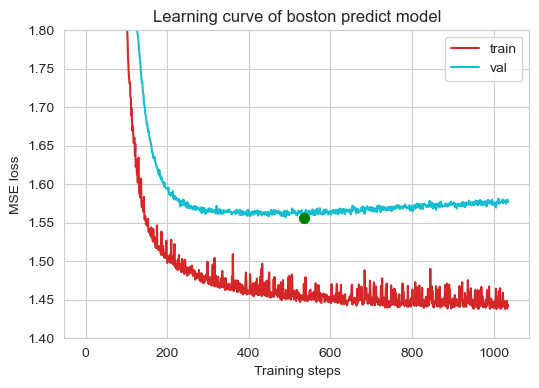

In [7]:
xutorch.plot.plot_learning_curve(loss_record, loss_name='MSE', title='boston predict model', bottom=1.4, top=1.8, min_loss_x=min_val_loss_epoch, min_loss_y=min_val_loss/len(val_dataset))

In [8]:
model.eval()
targets, preds = [], []
for X, y in val_loader:
    X, y = X.to(device), y.to(device)
    with torch.no_grad():
        pred = model(X)
        preds.append(pred.detach().cpu())
        targets.append(y.detach().cpu())

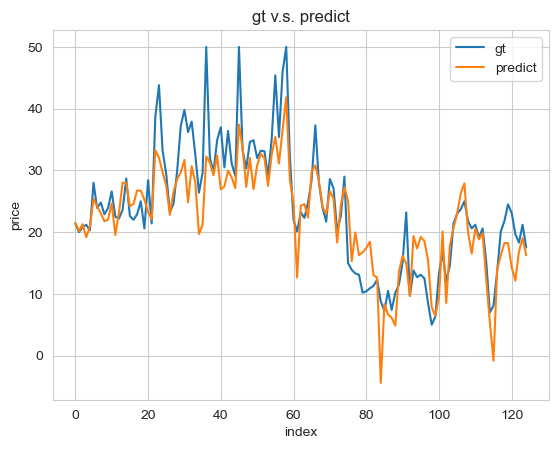

In [9]:
xutorch.plot.plot_gt_vs_pred(targets, preds)

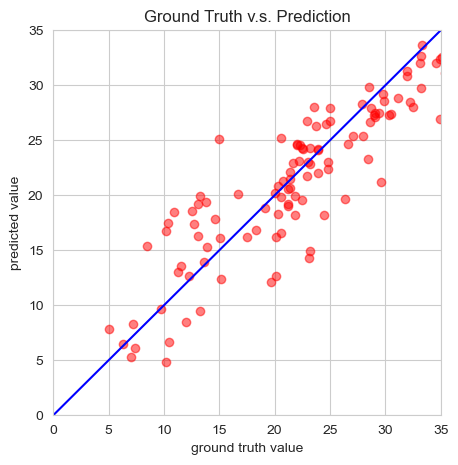

In [10]:
xutorch.plot.plot_gt_and_pred(targets, preds)

In [11]:
r2 = xutorch.misc.r2_score(targets, preds)
print("R2 score:", r2)

R2 score: 0.747869610786438


In [12]:
params = model.state_dict()

for name, param in params.items():
    print(name, param)

feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

feature_names[torch.max(model.fc.weight, 1)[1].item()], feature_names[torch.min(model.fc.weight, 1)[1].item()]

fc.weight tensor([[-0.6342,  1.0948,  0.6785,  0.5673, -2.5955,  2.6878,  0.1956, -3.0039,
          2.7394, -1.4655, -2.2621,  1.4881, -3.6845]], device='cuda:0')
fc.bias tensor([22.1328], device='cuda:0')


('RAD', 'LSTAT')